In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops,loopInterpolate,tailUpMs2,DespondsMs2Loops
from autocorrelationDataProcessing import tracePackageAutocorrelation
from autocorrelationAnalyticInference import fitAutocorrelationFunction

In [53]:
# define all needed parameters for simulation and fitting #
stepsize = 6            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0013
k_off = 0.003
duration = 3500   # seconds
num = 100           # number of traces in our simulated dataset

loop_function = SnailPromoterMs2Loops().loop_function

In [54]:
duration // stepsize

583

In [55]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [56]:
tracelist = tracePackage.tracelist
len(tracelist[1])

583

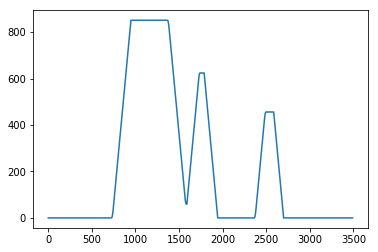

In [57]:
plt.plot(np.arange(len(tracelist[2]))*stepsize, tracelist[25])

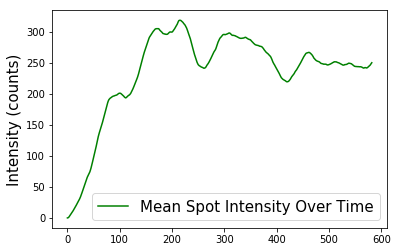

In [58]:
plt.plot(np.mean(tracelist, axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [59]:
# define start and stop indeces
start_index = 175
stop_index = -1

In [60]:
autopackage = tracePackageAutocorrelation(tracelist, loop_function, start_index, stop_index)

In [61]:
t = np.arange(len(autopackage.tracelist[1][1:]))

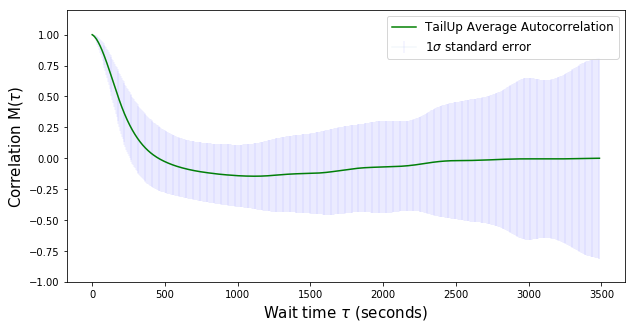

In [62]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
autoav = autopackage.autoav
autostd = autopackage.auto_err
avgflors = autopackage.avgflors

ax.plot(t*stepsize, autoav, color = 'g', label = "TailUp Average Autocorrelation")
ax.errorbar(x=t*stepsize, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'1$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

In [63]:
fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)

Pon                       =  0.29548405599609884
k_on + k_off              =  0.0051418633345060045 s^-1
k_on                      =  0.0015193386334574597
k_off                     =  0.003622524701048545
t_polII_block             =  6 seconds
characteristic timescale  =  194.48202625091227 seconds
covariance                =  1.1094855662959744e-08


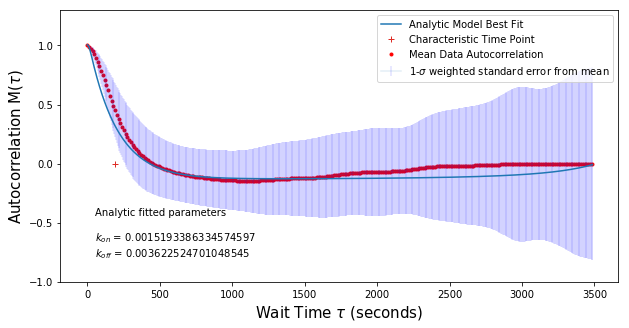

In [64]:
kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=True, 
                                                                                   upperbound=1/tPol, lowerbound=0.001,fitpon=True)

In [31]:
# something to plot with
t = np.arange(len(autoav))

In [32]:
np.linalg.eig(pcov)

(array([1.12811897e-08]), array([[1.]]))

In [33]:
# some tricks to get info we need to plot an ellipse, aligned with # some t 
#    the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(pcov)
angle = np.degrees(np.arctan2(eigvec[0,0], eigvec[0,0]))
w = 2*np.sqrt(eigval)
h=0

In [34]:
w

array([0.00021243])

In [35]:
pars = [kon_fit,koff_fit]

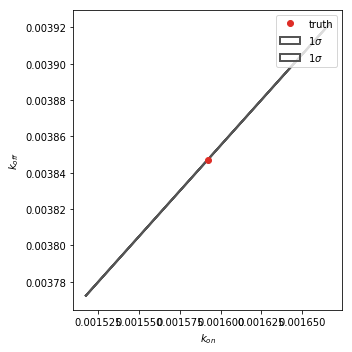

In [36]:
from  matplotlib.patches  import Ellipse

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,1]:
    ax.add_patch(Ellipse(pars, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax.plot(kon_fit, koff_fit, marker='o', zorder=10, linestyle='none',
        color='#de2d26', label='truth')

ax.set_xlabel('$k_{on}$')
ax.set_ylabel('$k_{off}$')
ax.legend(loc='best')

fig.tight_layout()

In [65]:
# Now create a loop to fit our MS2 Loop Construct to a range of parameters to test our inference.
# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

kon_range = np.linspace(start=0.001, stop=0.08, num=10)
# keep kon constant for the time being
#k_on_range = np.ones(10) * 0.016
koff_range = np.linspace(start=0.02, stop=0.11, num=10)

ksum_true = np.linspace(start=0.001, stop=0.05, num=10)

duration = 3000   # seconds
num = 80           # number of traces in each simulated dataset

pon = 0.2        # set pon to test inference

loop_function = SnailPromoterMs2Loops().loop_function


In [66]:
ksum_true

array([0.001     , 0.00644444, 0.01188889, 0.01733333, 0.02277778,
       0.02822222, 0.03366667, 0.03911111, 0.04455556, 0.05      ])

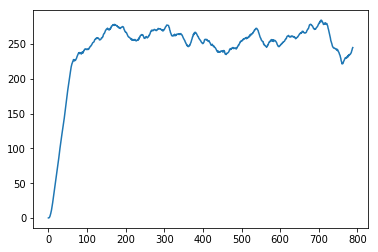

In [67]:
tracePackage = tracePackageSimulation(num, 0.027, 0.04, duration, stepsize, loop_function, k_elong, tPol)
plt.plot(np.mean(tracePackage.tracelist, axis=0))

In [68]:
start_index = 120
stop_index = -1

In [69]:
pon

0.2

In [ ]:
# create a new simulated trace package for each kon, koff to test inference
ksum_fit_list = []
kon_fit_list = []
koff_fit_list = []
for k in range(len(ksum_true)):
    # calculate kon and koff
    
    kon=ksum_true[k]*pon
    koff=ksum_true[k]*(1-pon)
    
    # simulated trace package
    tracePackage = tracePackageSimulation(num, kon, koff, duration, stepsize, loop_function, k_elong, tPol)
    # compute autocorrelation attributes
    autopackage = tracePackageAutocorrelation(tracePackage.tracelist, loop_function, start_index, stop_index)
    # create the fitting object
    fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)
    # fit function with a constant pon and store pars
    kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=False, 
                                                                                   upperbound=1/tPol, lowerbound=0.0005, fitpon=False, pon=pon)

    kon_fit_list.append(kon_fit)
    koff_fit_list.append(koff_fit)    
    ksum_fit_list.append(1/chrtime)
    
    print(k)

In [ ]:
ksum_fit_list

In [ ]:
np.asarray(ksum_fit_list),ksum_true

In [ ]:
pon

In [ ]:
ksum_fit_list = np.asarray(ksum_fit_list)
ksum_fit_list[0] = 0

In [ ]:
# Now plot the inferred parameters against the true inputs
fig,ax = plt.subplots(1, 1, figsize=(7,7), sharex=True)

ax.plot(ksum_true, np.asarray(ksum_fit_list), label='Inferred Parameters for Simulated Snail MS2 signal')
ax.plot(ksum_true, ksum_true, '--', color='k', label='True (kon + koff) Input Parameters')
#ax.set_xlim(0,0.15)
#ax.set_ylim(0,0.15)
ax.set_ylabel('Inferred kon + koff', fontsize=15)
ax.set_xlabel('True kon + koff', fontsize=15)
plt.legend(loc='best')
plt.show()

fig.savefig(fname='C:/Users/lucas/Documents/lucas-igmm/autocorrelation-paper/snail-pars')
#for i in autolist[1:]:

In [72]:
# do a bootstrap to find deviational ellipse in kon, koff to see how spread we are

# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

kon_true = 0.0013
koff_true = 0.0030

duration = 3000   # seconds
num = 100           # number of traces in each simulated dataset
loop_function = SnailPromoterMs2Loops().loop_function


In [ ]:
ntrials = 1000
konfit = []
kofffit = []
chartimefit = []
for k in range((ntrials)):
    
    # simulated trace package
    tracePackage = tracePackageSimulation(num, kon_true, koff_true, duration, stepsize, loop_function, k_elong, tPol)
    # compute autocorrelation attributes
    autopackage = tracePackageAutocorrelation(tracePackage.tracelist, loop_function, start_index, stop_index)
    # create the fitting object
    fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)
    # fit function with a constant pon and store pars
    kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=False, 
                                                                                   upperbound=1/tPol
                                                                             , lowerbound=0.0005, fitpon=True)

    konfit.append(kon_fit)
    kofffit.append(koff_fit)    
    chartimefit.append(1/chrtime)

In [ ]:
# Now plot the inferred parameters against the true inputs
fig,ax = plt.subplots(1, 1, figsize=(7,7), sharex=True)

ax.plot(konfit, kofffit, marker='.', color='b', alpha=0.3, label = "Fitted Points")
ax.plot(kon_true, koff_true, marker='+', color='r', zorder=10, label = "True parameters")

ax.set_xlabel('$k_on$ $s^{-1}$')
ax.set_ylabel('$k_off$ $s^{-1}$')

plt.legend(loc='best')
plt.show()